In [1]:
import numpy as np 
import scipy as sp
from file_parser import *
from scipy import signal
import pandas as pd
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
from ipywidgets import *
import seaborn as sns
import IPython
from IPython.display import Audio, Image
from IPython.core.display import display, HTML
display(HTML('<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.'))

/tmp/ipykernel_47449/1383674355.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# C and ASM Implementation Comparison
We implemented the 2nd order adaptive notch filter (ANF) in both C and assembly. To compare them, we use time domain plots, frequency domain analysis, plot spectograms and perform statistical analysis of the signal. 

The statistical analysis provides measures to compare the outputs, and the error analysis will directly quantify the differences between the two implementations.

In [2]:
input_signal = reads('../CCS_StartFiles/Assignment_2/data/input.pcm')/(2**12)
output_c = reads('../CCS_StartFiles/Assignment_2/data/output_c.pcm')/(2**12)
output_c_adaptive = reads('../CCS_StartFiles/Assignment_2/data/output_c_adaptive.pcm')/(2**12)
output_asm = reads('../CCS_StartFiles/Assignment_2/data/output_asm.pcm')/(2**12)
output_asm_adaptive = reads('../CCS_StartFiles/Assignment_2/data/output_asm_adaptive.pcm')/(2**12)

IPython.display.display(Audio(input_signal.T, rate=8000))
IPython.display.display(Audio(output_c.T, rate=8000))

The input signal itself is composed of two sinusoids of 1000 Hz and 1600 Hz, both with amplitude 0.5. Two sinusoids are concatenated such that, 1600 Hz sine wave comes after 1000 Hz sine wave. Finally, Gaussian noise with $\sigma=0.05$ is added. The signal is sampled at 8000 Hz. 

The implementation of 2nd order ANF ought to first attenuate 1000 Hz, and then adapt to attenuate 1600 Hz.

## Time Domain Analysis

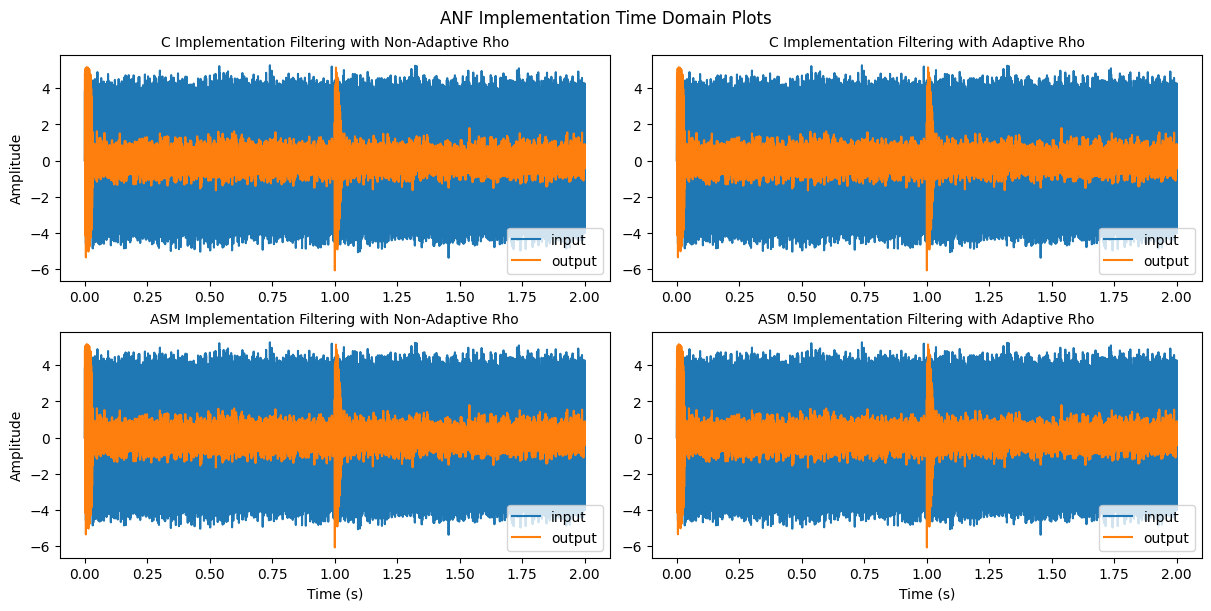

In [3]:
Fs = 8000
time = np.arange(0, len(input_signal)) / Fs

fig = plt.figure(layout='constrained', figsize=(12,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.suptitle('ANF Implementation Time Domain Plots')

ax1.plot(time, input_signal, label="input")
ax1.plot(time, output_c, label="output")
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.set_title("C Implementation Filtering with Non-Adaptive Rho", fontsize=10)

ax2.plot(time, input_signal, label="input")
ax2.plot(time, output_c_adaptive, label="output")
ax2.legend()
ax2.set_title("C Implementation Filtering with Adaptive Rho", fontsize=10)

ax3.plot(time, input_signal, label="input")
ax3.plot(time, output_asm, label="output")
ax3.set_ylabel('Amplitude')
ax3.set_xlabel('Time (s)')
ax3.legend()
ax3.set_title("ASM Implementation Filtering with Non-Adaptive Rho", fontsize=10)

ax4.plot(time, input_signal, label="input")
ax4.plot(time, output_asm_adaptive, label="output")
ax4.set_xlabel('Time (s)')
ax4.legend()
ax4.set_title("ASM Implementation Filtering with Adaptive Rho", fontsize=10)

plt.show()

The time domain plots show immediate differences in the output waveforms. With the naked eye, there aren't any significant differences between C and ASM implementations performance, nor between cases with adaptive and non-adaptive $\rho$.

## Frequency Domain Analysis

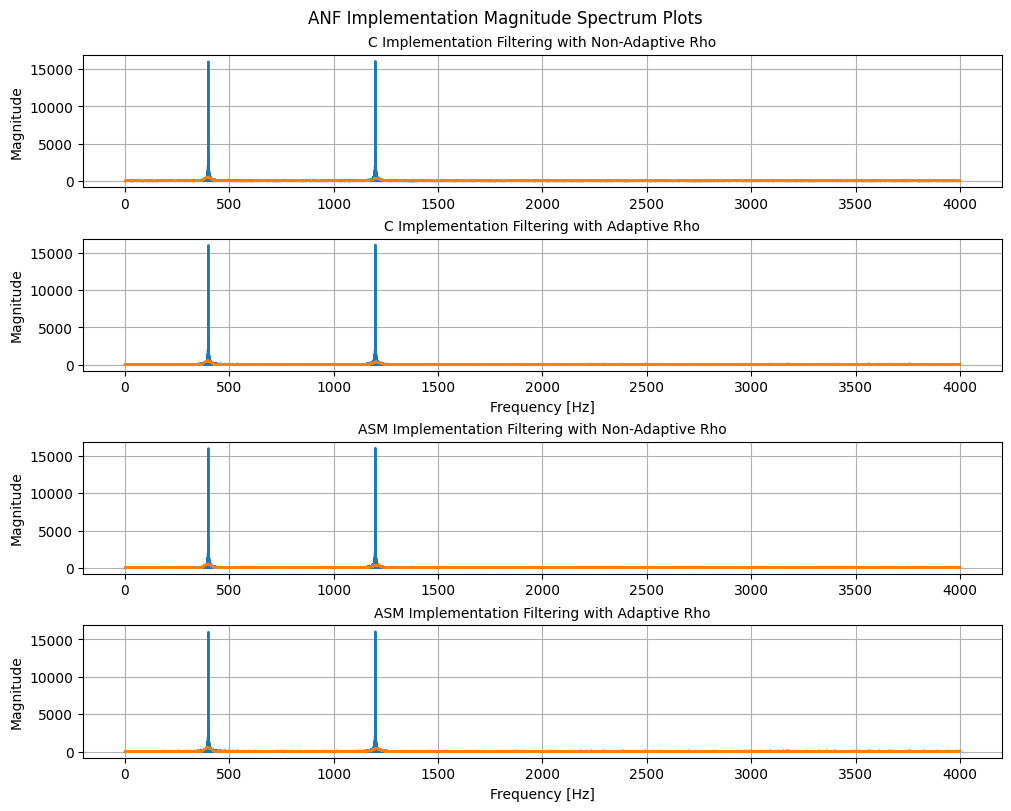

In [4]:
input_fft = np.fft.fft(input_signal)
input_freqs = np.fft.fftfreq(len(input_signal), 1/Fs)
output_c_fft = np.fft.fft(output_c)
output_c_freqs = np.fft.fftfreq(len(output_c), 1/Fs)
output_c_adaptive_fft = np.fft.fft(output_c_adaptive)
output_c_adaptive_freqs = np.fft.fftfreq(len(output_c_adaptive), 1/Fs)
output_asm_fft = np.fft.fft(output_asm)
output_asm_freqs = np.fft.fftfreq(len(output_asm), 1/Fs)
output_asm_adaptive_fft = np.fft.fft(output_asm_adaptive)
output_asm_adaptive_freqs = np.fft.fftfreq(len(output_asm_adaptive), 1/Fs)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, layout='constrained', figsize=(10, 8))
fig.suptitle('ANF Implementation Magnitude Spectrum Plots')

ax1.plot(input_freqs[:len(input_freqs)//2], np.abs(input_fft)[:len(input_fft)//2])
ax1.plot(output_c_freqs[:len(output_c_freqs)//2], np.abs(output_c_fft)[:len(input_fft)//2])
ax1.set_ylabel('Magnitude')
ax1.set_title("C Implementation Filtering with Non-Adaptive Rho", fontsize=10)
ax1.grid(True)

ax2.plot(input_freqs[:len(input_freqs)//2], np.abs(input_fft)[:len(input_fft)//2])
ax2.plot(output_c_adaptive_freqs[:len(output_c_adaptive_freqs)//2], np.abs(output_c_adaptive_fft)[:len(output_c_adaptive_fft)//2])
ax2.set_ylabel('Magnitude')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_title("C Implementation Filtering with Adaptive Rho", fontsize=10)
ax2.grid(True)

ax3.plot(input_freqs[:len(input_freqs)//2], np.abs(input_fft)[:len(input_fft)//2])
ax3.plot(output_asm_freqs[:len(output_asm_freqs)//2], np.abs(output_asm_fft)[:len(output_asm_fft)//2])
ax3.set_ylabel('Magnitude')
ax3.set_title("ASM Implementation Filtering with Non-Adaptive Rho", fontsize=10)
ax3.grid(True)

ax4.plot(input_freqs[:len(input_freqs)//2], np.abs(input_fft)[:len(input_fft)//2])
ax4.plot(output_asm_adaptive_freqs[:len(output_asm_adaptive_freqs)//2], np.abs(output_asm_adaptive_fft)[:len(output_asm_adaptive_fft)//2])
ax4.set_ylabel('Magnitude')
ax4.set_xlabel('Frequency [Hz]')
ax4.set_title("ASM Implementation Filtering with Adaptive Rho", fontsize=10)
ax4.grid(True)

plt.show()

The frequency domain analysis reveals any differences in how the implementations affect different frequency components. 

## Spectograms

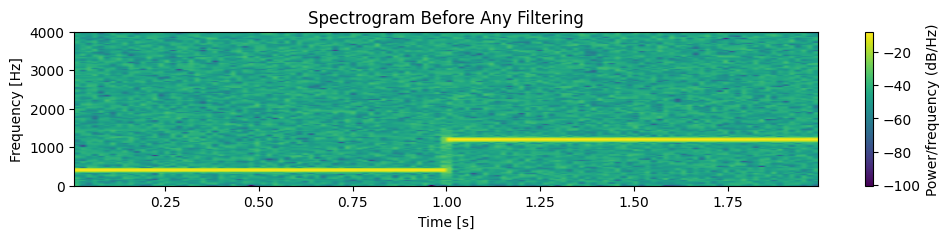

In [5]:
plt.figure(figsize=(12,2))
plt.specgram(input_signal, Fs=8000)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram Before Any Filtering")
plt.colorbar().set_label("Power/frequency (dB/Hz)")
plt.show()

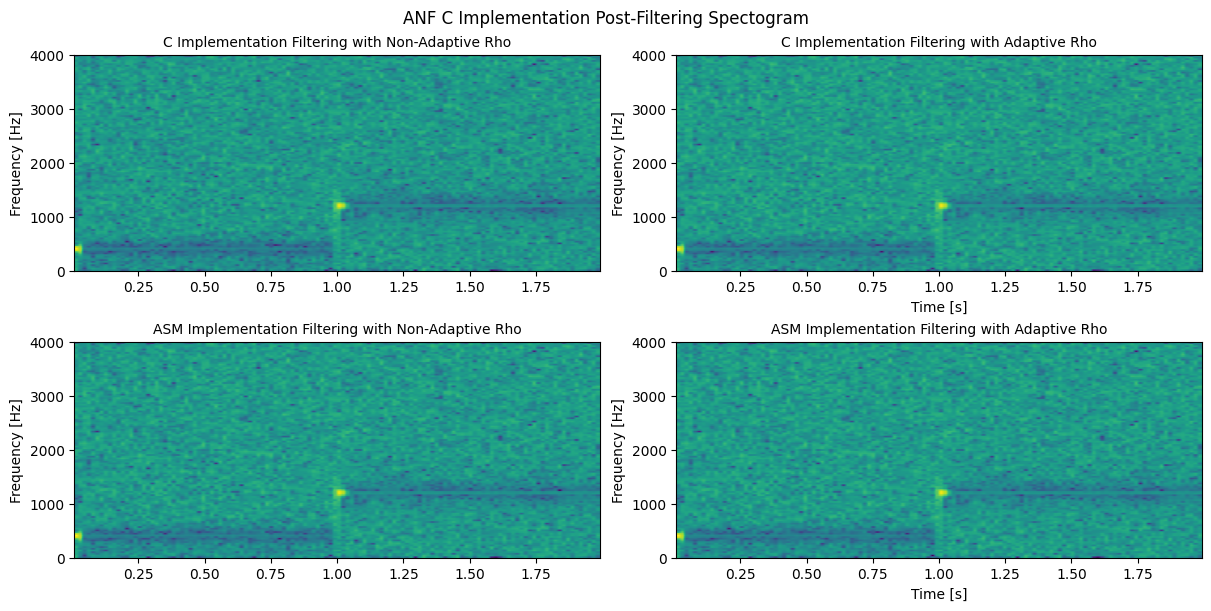

In [6]:
fig = plt.figure(layout='constrained', figsize=(12,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.suptitle('ANF C Implementation Post-Filtering Spectogram')

ax1.specgram(output_c, Fs=8000)
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title("C Implementation Filtering with Non-Adaptive Rho", fontsize=10)

ax2.specgram(output_c_adaptive, Fs=8000)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_title("C Implementation Filtering with Adaptive Rho", fontsize=10)

ax3.specgram(output_asm, Fs=8000)
ax3.set_ylabel("Frequency [Hz]")
ax3.set_title("ASM Implementation Filtering with Non-Adaptive Rho", fontsize=10)

ax4.specgram(output_asm_adaptive, Fs=8000)
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Frequency [Hz]")
ax4.set_title("ASM Implementation Filtering with Adaptive Rho", fontsize=10)

plt.show()

The spectrograms show how the frequency content changes over time for each implementation. 

## Statistical Analysis

In [7]:
print("-------------------------------------------")
print("INPUT SIGNAL")
print(f"Mean: {np.mean(input_signal)}")
print(f"Standard Deviation: {np.std(input_signal)}")
print(f"Max: {np.max(input_signal)}")
print(f"Min: {np.min(input_signal)}")
print(f"RMS: {np.sqrt(np.mean(input_signal**2))}")
print("-------------------------------------------")
print("OUTPUT C")
print(f"Mean: {np.mean(output_c)}")
print(f"Standard Deviation: {np.std(output_c)}")
print(f"Max: {np.max(output_c)}")
print(f"Min: {np.min(output_c)}")
print(f"RMS: {np.sqrt(np.mean(output_c**2))}")
print("-------------------------------------------")
print("OUTPUT C ADAPTIVE")
print(f"Mean: {np.mean(output_c_adaptive)}")
print(f"Standard Deviation: {np.std(output_c_adaptive)}")
print(f"Max: {np.max(output_c_adaptive)}")
print(f"Min: {np.min(output_c_adaptive)}")
print(f"RMS: {np.sqrt(np.mean(output_c_adaptive**2))}")
print("-------------------------------------------")
print("OUTPUT ASM")
print(f"Mean: {np.mean(output_asm)}")
print(f"Standard Deviation: {np.std(output_asm)}")
print(f"Max: {np.max(output_asm)}")
print(f"Min: {np.min(output_asm)}")
print(f"RMS: {np.sqrt(np.mean(output_asm**2))}")
print("-------------------------------------------")
print("OUTPUT ASM ADAPTIVE")
print(f"Mean: {np.mean(output_asm_adaptive)}")
print(f"Standard Deviation: {np.std(output_asm_adaptive)}")
print(f"Max: {np.max(output_asm_adaptive)}")
print(f"Min: {np.min(output_asm_adaptive)}")
print(f"RMS: {np.sqrt(np.mean(output_asm_adaptive**2))}")
print("-------------------------------------------")

-------------------------------------------
INPUT SIGNAL
Mean: 0.001272674560546875
Standard Deviation: 2.8590610278258404
Max: 5.272216796875
Min: -5.373291015625
RMS: 2.8590613110832526
-------------------------------------------
OUTPUT C
Mean: 0.001717529296875
Standard Deviation: 0.6583709486329637
Max: 5.171630859375
Min: -6.07177734375
RMS: 0.6583731889367566
-------------------------------------------
OUTPUT C ADAPTIVE
Mean: 0.00171343994140625
Standard Deviation: 0.6581367793128049
Max: 5.166015625
Min: -6.0732421875
RMS: 0.6581390097545233
-------------------------------------------
OUTPUT ASM
Mean: 0.0006730804443359375
Standard Deviation: 0.6588202054582679
Max: 5.173583984375
Min: -6.073486328125
RMS: 0.658820549282852
-------------------------------------------
OUTPUT ASM ADAPTIVE
Mean: 0.00069757080078125
Standard Deviation: 0.6588149774238746
Max: 5.166259765625
Min: -6.075927734375
RMS: 0.6588153467270192
-------------------------------------------


## Spectrograms

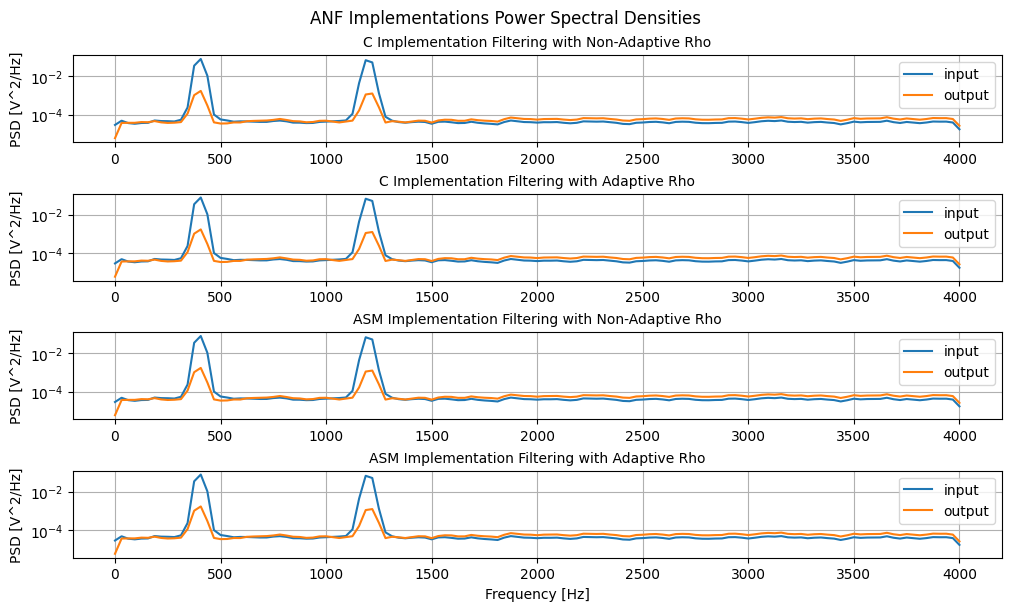

In [8]:
input_f, input_Pxx = signal.welch(input_signal, Fs)
output_c_f, output_c_Pxx = signal.welch(output_c, Fs)
output_c_adaptive_f, output_c_adaptive_Pxx = signal.welch(output_c_adaptive, Fs)
output_asm_f, output_asm_Pxx = signal.welch(output_asm, Fs)
output_asm_adaptive_f, output_asm_adaptive_Pxx = signal.welch(output_asm_adaptive, Fs)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, layout='constrained', figsize=(10, 6),)
fig.suptitle('ANF Implementations Power Spectral Densities')

ax1.semilogy(input_f, input_Pxx, label="input")
ax1.semilogy(output_c_f, output_c_Pxx, label="output")
ax1.set_title('C Implementation Filtering with Non-Adaptive Rho', fontsize=10)
ax1.set_ylabel('PSD [V^2/Hz]')
ax1.legend()
ax1.grid(True)

ax2.semilogy(input_f, input_Pxx, label="input")
ax2.semilogy(output_c_adaptive_f, output_c_adaptive_Pxx, label="output")
ax2.set_title('C Implementation Filtering with Adaptive Rho', fontsize=10)
ax2.set_ylabel('PSD [V^2/Hz]')
ax2.legend()
ax2.grid(True)

ax3.semilogy(input_f, input_Pxx, label="input")
ax3.semilogy(output_asm_f, output_asm_Pxx, label="output")
ax3.set_title('ASM Implementation Filtering with Non-Adaptive Rho', fontsize=10)
plt.xlabel('Frequency [Hz]')
ax3.set_ylabel('PSD [V^2/Hz]')
ax3.legend()
ax3.grid(True)

ax4.semilogy(input_f, input_Pxx, label="input")
ax4.semilogy(output_asm_adaptive_f, output_asm_Pxx, label="output")
ax4.set_title('ASM Implementation Filtering with Adaptive Rho', fontsize=10)
ax4.set_xlabel('Frequency [Hz]')
ax4.set_ylabel('PSD [V^2/Hz]')
ax4.legend()
ax4.grid(True)

plt.show()

# ANF Output Analysis
We make time domain plots, frequency domain analysis, plot spectograms and perform statistical analysis of the signal. We used fridge hum signal.

In [9]:
fridge_buzz = reads('../CCS_StartFiles/Assignment_2/data/fridge-buzz.pcm')/(2**15)
fridge_buzz_c = reads('../CCS_StartFiles/Assignment_2/data/fridge-buzz_c.pcm')/(2**15)
fridge_buzz_asm = reads('../CCS_StartFiles/Assignment_2/data/fridge-buzz_asm.pcm')/(2**15)

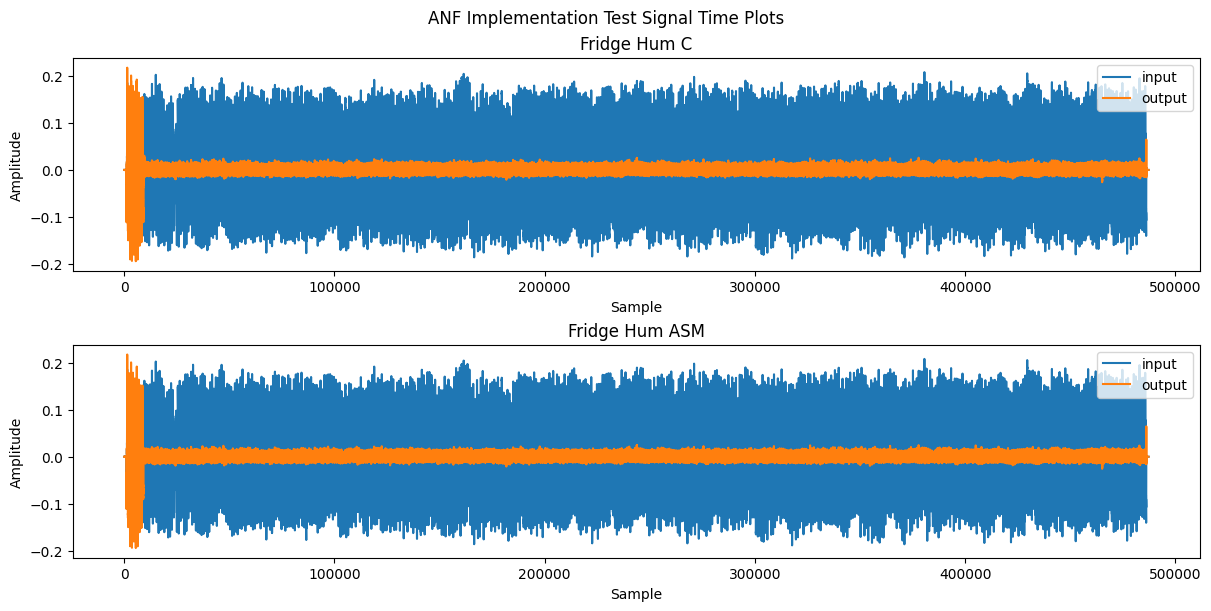

In [10]:
fig = plt.figure(layout='constrained', figsize=(12,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.suptitle('ANF Implementation Test Signal Time Plots')

ax1.plot(fridge_buzz)
ax1.plot(fridge_buzz_c)
ax1.set_title('Fridge Hum C')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.legend(['input', 'output'])

ax2.plot(fridge_buzz)
ax2.plot(fridge_buzz_asm)
ax2.set_title('Fridge Hum ASM')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Amplitude')
ax2.legend(['input', 'output'])

plt.show()

/home/wiktoria/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


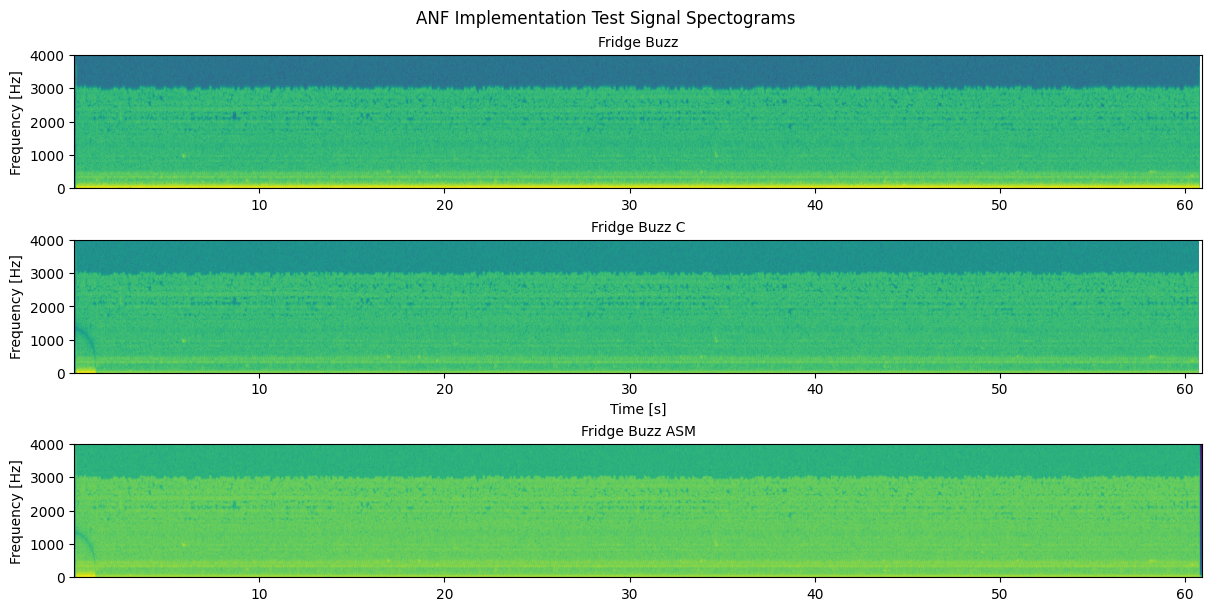

In [11]:
fig = plt.figure(layout='constrained', figsize=(12,6))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
fig.suptitle('ANF Implementation Test Signal Spectograms')

ax1.specgram(fridge_buzz, Fs=8000)
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title("Fridge Buzz", fontsize=10)

ax2.specgram(fridge_buzz_c, Fs=8000)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_title("Fridge Buzz C", fontsize=10)

ax3.specgram(fridge_buzz_asm, Fs=8000)
ax3.set_ylabel("Frequency [Hz]")
ax3.set_title("Fridge Buzz ASM", fontsize=10)

plt.show()

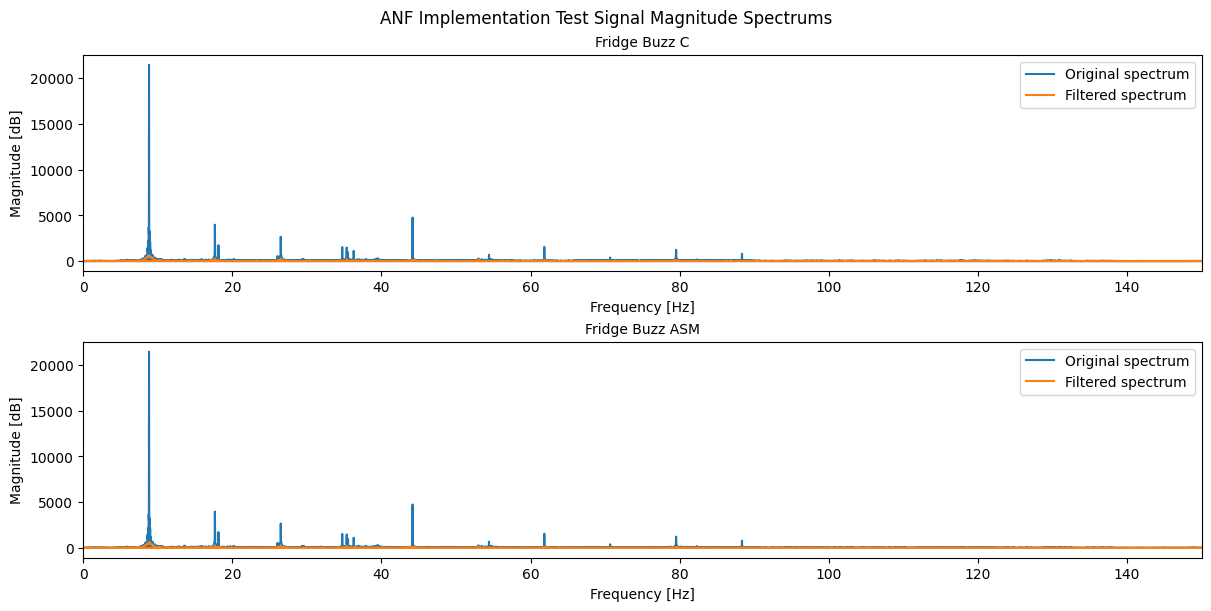

In [12]:
fft_result_original = np.fft.fft(fridge_buzz)
fft_freq_original = np.fft.fftfreq(len(fridge_buzz), 1/8000)

fft_result_c = np.fft.fft(fridge_buzz_c)
fft_freq_c = np.fft.fftfreq(len(fridge_buzz_c), 1/8000)

fft_result_asm = np.fft.fft(fridge_buzz_asm)
fft_freq_asm = np.fft.fftfreq(len(fridge_buzz_asm), 1/8000)

magnitude_original = np.abs(fft_result_original)
magnitude_c = np.abs(fft_result_c)
magnitude_asm = np.abs(fft_result_asm)

fig = plt.figure(layout='constrained', figsize=(12,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.suptitle('ANF Implementation Test Signal Magnitude Spectrums')

ax1.plot(fft_freq_original, magnitude_original)
ax1.plot(fft_freq_c, magnitude_c)
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Magnitude [dB]")
ax1.set_title("Fridge Buzz C", fontsize=10)
ax1.set_xlim(0, 150)
ax1.legend(['Original spectrum', 'Filtered spectrum'])

ax2.plot(fft_freq_original, magnitude_original)
ax2.plot(fft_freq_asm, magnitude_asm)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Magnitude [dB]")
ax2.set_title("Fridge Buzz ASM", fontsize=10)
ax2.set_xlim(0, 150)
ax2.legend(['Original spectrum', 'Filtered spectrum'])

plt.show()